# Thử ngồi code hết mấy cái CNN tìm hiểu được 2

##I. Dataset: CIFAR-10

In [1]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from pathlib import Path
import torch.nn.functional as F

In [2]:
#Load train and test data
train_data = torchvision.datasets.CIFAR10(root='dataset', train=True,
                                          download=True,
                                          transform=ToTensor(),
                                          target_transform=None)
test_data = torchvision.datasets.CIFAR10(root='dataset', train=False,
                                         download=True, transform=ToTensor(),
                                         target_transform=None)

100%|██████████| 170M/170M [00:08<00:00, 20.1MB/s]


Extracting dataset/cifar-10-python.tar.gz to dataset
Files already downloaded and verified


In [3]:
len(train_data), len(test_data)

(50000, 10000)

In [4]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: dataset
    Split: Train
    StandardTransform
Transform: ToTensor()

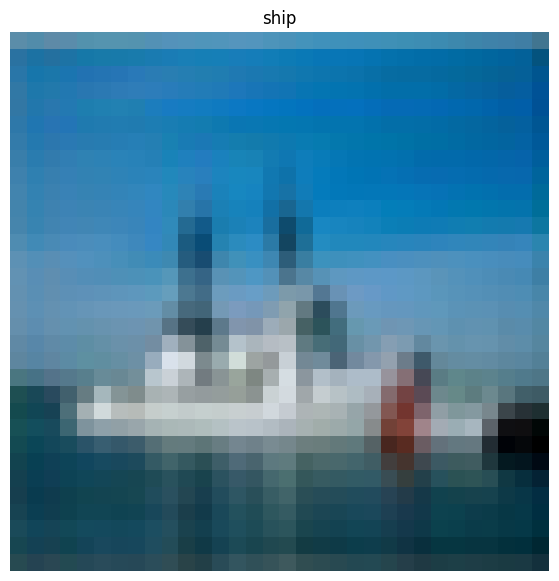

(32, 32, 3)

In [5]:
#Select random image
torch.manual_seed(13)
idx = torch.randint(0 , len(train_data), size  = [1])
image, label = train_data[idx]

#Get image class
class_names = train_data.classes

# Convert (C, H, W) to (H, W, C)
image = image.permute(1,2,0)
image = image.numpy()

#Show image
plt.figure(figsize=(10,7))
plt.axis('off')
plt.imshow(image)
plt.title(class_names[label])
plt.show()
image.shape

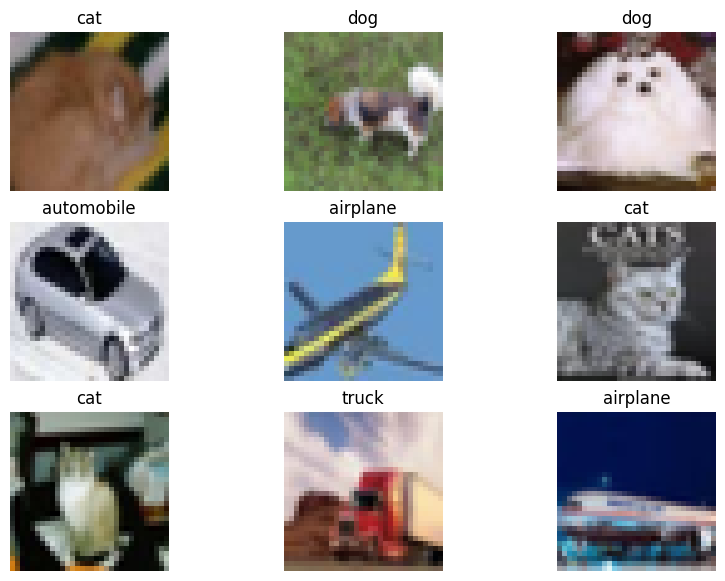

In [6]:
torch.manual_seed(24)
pic = plt.figure(figsize= (10,7))
rows = 3
columns = 3
for i in range(rows * columns):
  idx = torch.randint(0, len(train_data), size=[1])
  image, label = train_data[idx]

  image = image.permute(1,2,0)
  image = image.numpy()
  pic.add_subplot(rows, columns, i+ 1)
  plt.imshow(image)
  plt.title(class_names[label])
  plt.axis('off')
plt.show()

In [7]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset = train_data,
                              batch_size = BATCH_SIZE,
                              shuffle=True)
test_dataloader = DataLoader(dataset = test_data,
                             batch_size = BATCH_SIZE,
                             shuffle=False)


## Get some helper function

In [8]:
import requests
from pathlib import Path

if Path('helper_functions.py').is_file():
  print("Helper functions already exists, skipping dowload" )
else:
  print("Download helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/huhj225131/SomeCNN/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

Download helper_functions.py


In [9]:
from helper_functions import *

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [11]:
# Create directory to store models
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok = True)

## CNN

###Network in Network
Basically, this network doesn't need a fully connected layer in the end.Instead, it uses 1 x 1 kernel in NiN block to compute features for each pixel in images

In [ ]:
def NiN_block(kernel, output, stride, padding):
  block = []
  block.append(nn.LazyConv2d(out_channels=output,kernel_size=kernel, stride=stride, padding=padding))
  block.append(nn.ReLU())
  for i in range(2):
    block.append(nn.Conv2d(in_channels=output,out_channels=output,kernel_size=1))
    block.append(nn.ReLU())
  return nn.Sequential(*block)

In [ ]:
class NiN(nn.Module):
  def __init__(self,arch,output_channels):
    super().__init__()
    self.conv_net = []
    for  output ,kernel, stride, padding in arch:
      self.conv_net.append(NiN_block(kernel, output, stride, padding))
      self.conv_net.append(nn.MaxPool2d(kernel_size=3, stride=2))
    self.conv_net.append(nn.Dropout(0.5))
    self.conv_net.append(NiN_block(3, output_channels, 1, 1))
    self.conv_net.append(nn.AdaptiveAvgPool2d(1))
    self.conv_net.append(nn.Flatten())
    self.conv_net = nn.Sequential(*self.conv_net)

  def forward(self, X):
    return self.conv_net(X)

In [ ]:
arch = [(96, 5,3,0), (256,2,1,2), (384,3,1,1)]
NiN_model = NiN(arch, len(class_names))
# NiN_model.apply(init_cnn_he)

In [ ]:
dummy_input = torch.rand(1,3,32,32)
dummy_output = NiN_model(dummy_input)

In [ ]:
NiN_model.apply(init_cnn_he)

NiN(
  (conv_net): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 96, kernel_size=(5, 5), stride=(3, 3))
      (1): ReLU()
      (2): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1))
      (3): ReLU()
      (4): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1))
      (5): ReLU()
    )
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Sequential(
      (0): Conv2d(96, 256, kernel_size=(2, 2), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
      (2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
      (3): ReLU()
      (4): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
      (5): ReLU()
    )
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(384, 384, kernel_size=(1, 1), stride=(1, 1))
      (3): ReLU()
      (4): Conv2d(384, 384, kernel_size=(1, 1), stride

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(NiN_model.parameters(), lr = 0.1)

In [ ]:
#Create save path
MODEL_NAME = "NiN.pth"

MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

MODEL_SAVE_PATH

PosixPath('models/NiN.pth')

In [ ]:
_, best_acc = eval_model(NiN_model, test_dataloader, loss_fn, accuracy_fn, device )
best_acc


59.844249201277954

In [ ]:
train, test = train_test_model(NiN_model, train_dataloader,
                 test_dataloader,loss_fn, accuracy_fn, optimizer,MODEL_SAVE_PATH,
                22, device, best_acc)

  0%|          | 0/22 [00:00<?, ?it/s]

model tốt đấy, lưu nhé
Epoch: 0 | Train loss: 2.140012264251709 | Train accuracy: 18.316138835572616 | Test loss: 1.8886979818344116 | Test_acc: 26.367811501597444
model tốt đấy, lưu nhé
Epoch: 1 | Train loss: 1.814509391784668 | Train accuracy: 29.84045105566219 | Test loss: 1.6884874105453491 | Test_acc: 36.671325878594246
model tốt đấy, lưu nhé
Epoch: 2 | Train loss: 1.6461323499679565 | Train accuracy: 37.983845169545745 | Test loss: 1.531860113143921 | Test_acc: 43.650159744408946
model tốt đấy, lưu nhé
Epoch: 3 | Train loss: 1.5433878898620605 | Train accuracy: 43.35212731925784 | Test loss: 1.4539388418197632 | Test_acc: 46.944888178913736
model tốt đấy, lưu nhé
Epoch: 4 | Train loss: 1.4557228088378906 | Train accuracy: 47.55478246960973 | Test loss: 1.4471452236175537 | Test_acc: 47.8035143769968
model tốt đấy, lưu nhé
Epoch: 5 | Train loss: 1.389695167541504 | Train accuracy: 50.541826615483046 | Test loss: 1.412922978401184 | Test_acc: 49.04153354632588
model tốt đấy, lưu nh

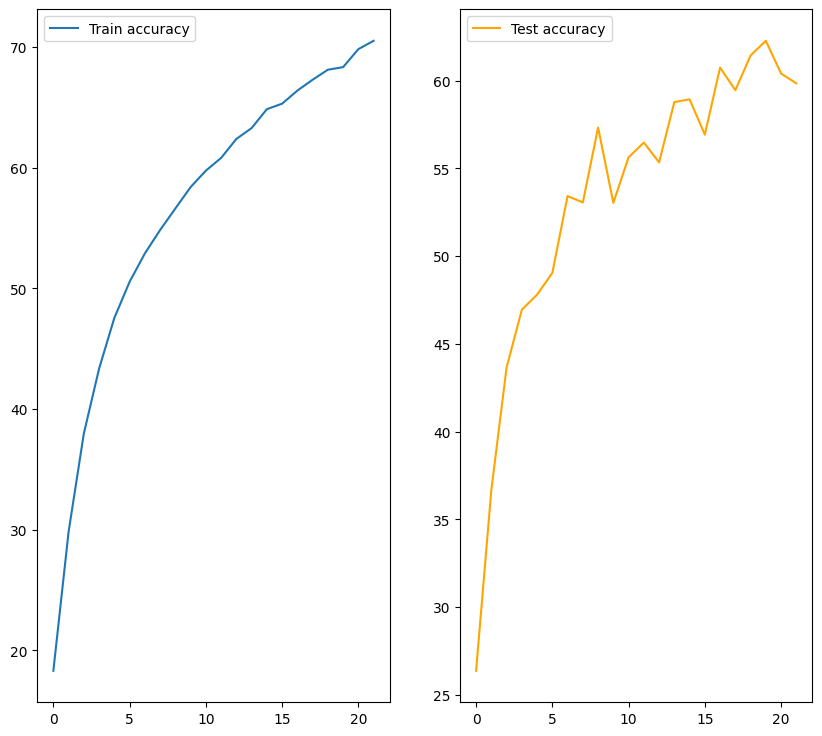

In [ ]:
plot_trainning_progress(train, test) #Train lượt 1 15 epochs

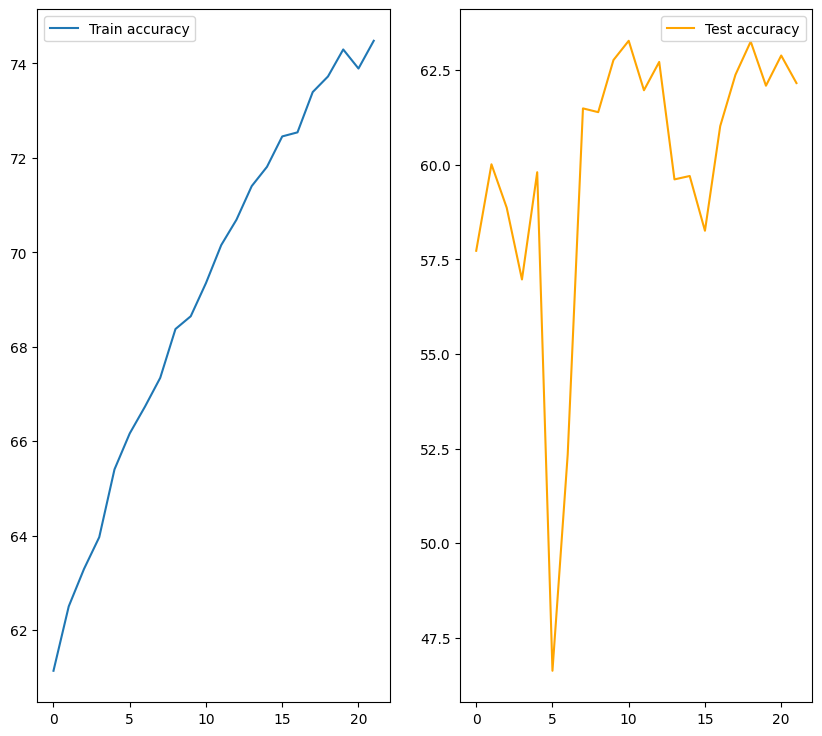

In [ ]:
plot_trainning_progress(train, test) #Train lượt 2 22 epochs

In [ ]:
NiN_model.load_state_dict(torch.load(MODEL_SAVE_PATH,weights_only=True))
eval_model(NiN_model,test_dataloader,loss_fn,accuracy_fn,device)

(tensor(1.1673, device='cuda:0'), 63.27875399361022)

###Google Net inspired network ( because the origin model's used for 224 x 224 and it's relatively big to train :)) )

In [ ]:
#Inception is composed of many different kernel. It is because a research won in 2014
#ImageNet competition indentified that trainning with variety kernel may be effective

class Inception(nn.Module):
    def __init__(self, in_channels, c1, c2, c3, c4):
        super(Inception, self).__init__()
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, c1, kernel_size=1), nn.ReLU()
        )

        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, c2[0], kernel_size=1), nn.ReLU(),
            nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1), nn.ReLU()
        )

        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, c3[0], kernel_size=1), nn.ReLU(),
            nn.Conv2d(c3[0], c3[1], kernel_size=3, padding=1), nn.ReLU()
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, c4, kernel_size=1), nn.ReLU()
        )

    def forward(self, x):
        return torch.cat([
            self.branch1(x),
            self.branch2(x),
            self.branch3(x),
            self.branch4(x)
        ], dim=1)

In [ ]:
class Google_Net(nn.Module):
    def __init__(self):
        super(Google_Net, self).__init__()

        self.b1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.b2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=1), nn.ReLU(),
            nn.Conv2d(64, 192, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.b3 = nn.Sequential(
            Inception(192, 64, (96, 128), (16, 32), 32),
            Inception(256, 128, (128, 192), (32, 96), 64),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.b4 = nn.Sequential(
            Inception(256, 96, (96, 208), (16, 48), 64),
            Inception(256, 112, (112, 224), (24, 64), 64),
            Inception(256, 128, (128, 256), (24, 64), 64),
            Inception(256, 144, (144, 288), (32, 64), 64),
            Inception(256, 160, (160, 320), (32, 128), 128),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.b5 = nn.Sequential(
            Inception(256, 160, (160, 320), (32, 128), 128),
            Inception(384, 192, (192, 384), (48, 128), 128),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.fc = nn.Linear(1024, 10)  # 1024 là tổng số kênh đầu ra

    def forward(self, x):
        x = self.b1(x)
        x = self.b2(x)
        x = self.b3(x)
        x = self.b4(x)
        x = self.b5(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


In [ ]:
gg_model = Google_Net()

In [ ]:
sum(p.numel() for p in gg_model.parameters())

4272714

In [ ]:
gg_model.apply(init_cnn_he)

Google_Net(
  (b1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (b2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (b3): Sequential(
    (0): Inception(
      (branch1): Sequential(
        (0): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU()
      )
      (branch2): Sequential(
        (0): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU()
        (2): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
      (branch3): Sequential(
        (0): Conv2d(192, 16, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU()
        (2): Conv2d(

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(gg_model.parameters(), lr = 0.1)

In [ ]:
#Create save path
MODEL_NAME = "gg.pth"

MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

MODEL_SAVE_PATH

PosixPath('models/gg.pth')

In [ ]:
_, best_acc = eval_model(gg_model, test_dataloader, loss_fn, accuracy_fn, device )
best_acc


NameError: name 'NiN_model' is not defined

In [ ]:
train, test = train_test_model(gg_model, train_dataloader,
                 test_dataloader,loss_fn, accuracy_fn, optimizer,MODEL_SAVE_PATH,
                22, device, best_acc)

### residual block from resnet

In [ ]:
class residual_block(nn.Module):
  def __init__(self, input_channels, output_channels,stride = 1, use_1x1conv=False):
    super().__init__()
    self.use_1x1conv = use_1x1conv
    self.l1 = nn.Sequential(
        nn.Conv2d(in_channels=input_channels,out_channels=output_channels, padding = 1, kernel_size = 3, stride = stride),
        nn.BatchNorm2d(output_channels),
        nn.ReLU()
    )
    self.l2 = nn.Sequential(
        nn.Conv2d(in_channels = output_channels,out_channels = output_channels, padding = 1,
                  kernel_size = 3
                  ,stride = 1),
        nn.BatchNorm2d(output_channels)
    )
    if use_1x1conv:
      self.l3 = nn.Conv2d(in_channels=input_channels,out_channels = output_channels,  kernel_size =1
                          ,stride = stride)

  def forward(self, X):
    A = self.l1(X)
    A = self.l2(A)
    if self.use_1x1conv:
      X = self.l3(X)
    return F.relu(A + X)

In [ ]:
class Res_Net(nn.Module):
  def __init__(self, input, output):
    super().__init__()
    self.conv_1 = nn.Sequential(
        nn.Conv2d(in_channels=input, out_channels=16, kernel_size=3, padding = 1),
        nn.BatchNorm2d(16),
        nn.ReLU()
    )
    self.res_1 = nn.Sequential(residual_block(16, 16), residual_block(16,16))
    self.res_2 = nn.Sequential(
        residual_block(16, 32, stride = 2, use_1x1conv=True),
        residual_block(32, 32)
    )
    self.res_3 = nn.Sequential(
        residual_block(32, 64, stride = 2, use_1x1conv=True),
        residual_block(64, 64)
    )
    self.avg_pool = nn.AdaptiveAvgPool2d(1)
    self.flatten = nn.Flatten()
    self.fc = nn.Linear(64, output)
  def forward(self, X):
    X = self.conv_1(X)
    X = self.res_1(X)
    X = self.res_2(X)
    X = self.res_3(X)
    return self.fc(self.flatten(self.avg_pool(X)))


In [ ]:
model_res = Res_Net(3, len(class_names))

In [ ]:
dummy_input = torch.rand((1,3,32,32))
model_res(dummy_input)

tensor([[-0.1633,  0.4888, -0.5030, -0.0057,  0.1374, -0.0061, -1.2244,  0.4070,
          1.1562,  0.7367]], grad_fn=<AddmmBackward0>)

In [ ]:
model_res.apply(init_cnn_he)

Res_Net(
  (conv_1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (res_1): Sequential(
    (0): residual_block(
      (l1): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (l2): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): residual_block(
      (l1): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (l2): Sequential(
        (0): Conv2d(16, 16, k

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_res.parameters(), lr = 0.1)

In [ ]:
#Create save path
MODEL_NAME = "res.pth"

MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

MODEL_SAVE_PATH

PosixPath('models/res.pth')

In [ ]:
_, best_acc = eval_model(model_res, test_dataloader, loss_fn, accuracy_fn, device )
best_acc


10.033945686900958

In [ ]:
train, test = train_test_model(model_res, train_dataloader,
                 test_dataloader,loss_fn, accuracy_fn, optimizer,MODEL_SAVE_PATH,
                22, device, best_acc)

  0%|          | 0/22 [00:00<?, ?it/s]

model tốt đấy, lưu nhé
Epoch: 0 | Train loss: 1.3977011442184448 | Train accuracy: 48.83837172104926 | Test loss: 1.2325575351715088 | Test_acc: 56.409744408945684
model tốt đấy, lưu nhé
Epoch: 1 | Train loss: 0.9842886328697205 | Train accuracy: 65.01919385796545 | Test loss: 0.8925617337226868 | Test_acc: 68.14097444089457
model tốt đấy, lưu nhé
Epoch: 2 | Train loss: 0.8075636029243469 | Train accuracy: 71.5331094049904 | Test loss: 0.8668707013130188 | Test_acc: 68.95966453674122
model tốt đấy, lưu nhé
Epoch: 3 | Train loss: 0.6952085494995117 | Train accuracy: 75.63579654510556 | Test loss: 0.8066873550415039 | Test_acc: 72.04472843450479
Epoch: 4 | Train loss: 0.6189029812812805 | Train accuracy: 78.4848848368522 | Test loss: 0.8589537143707275 | Test_acc: 69.76837060702876
model tốt đấy, lưu nhé
Epoch: 5 | Train loss: 0.5527417063713074 | Train accuracy: 80.64219449776071 | Test loss: 0.6678000688552856 | Test_acc: 77.23642172523962
Epoch: 6 | Train loss: 0.5035355687141418 | Tr

###DenseNet

In [12]:
class DenseBlock(nn.Module):
  def __init__(self, num_layers, in_channels, growth_rate ):
    super().__init__()
    self.layers = nn.ModuleList()

    for i in range(num_layers):
      layer_in_channels = in_channels + i * growth_rate
      self.layers.append(self._make_layer(layer_in_channels, growth_rate))
  def _make_layer(self, in_channels, growth_rate):
    return nn.Sequential(
        nn.BatchNorm2d(in_channels),
        nn.ReLU(),
        nn.Conv2d(in_channels, growth_rate, kernel_size=3, padding = 1, bias = False)
    )
  def forward(self, X):
    features = [X]
    for layer in self.layers:
      new_feature = layer(torch.cat(features,dim=1))
      features.append(new_feature)
    return torch.cat(features, dim=1)

In [13]:
class TransitionLayer(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.conv = nn.Sequential(
        nn.BatchNorm2d(in_channels),
        nn.ReLU(),
        nn.Conv2d(in_channels, out_channels, kernel_size=1 )
    )
    self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

  def forward(self, X):
    return self.pool(self.conv(X))


In [14]:
class DenseNet(nn.Module):
  def __init__(self, in_channels, num_classes, growth_rate= 12):
    super().__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels, 16, kernel_size=3, padding = 1),
        nn.BatchNorm2d(16),
        nn.ReLU(inplace=True)
    )
    self.dense1 = DenseBlock(num_layers=2, in_channels=16, growth_rate=growth_rate)
    self.trans1 = TransitionLayer(in_channels=16 + 2 * growth_rate, out_channels=32)

        # DenseBlock 2 (32 → 32+2*growth_rate)
    self.dense2 = DenseBlock(num_layers=2, in_channels=32, growth_rate=growth_rate)
    self.trans2 = TransitionLayer(in_channels=32 + 2 * growth_rate, out_channels=64)

        # DenseBlock 3 (64 → 64+2*growth_rate)
    self.dense3 = DenseBlock(num_layers=2, in_channels=64, growth_rate=growth_rate)

        # Avg Pool + Fully Connected Layer
    self.avg_pool = nn.AdaptiveAvgPool2d(1)
    self.fc = nn.Linear(64 + 2 * growth_rate, num_classes)
  def forward(self, x):
          x = self.conv1(x)
          x = self.dense1(x)
          x = self.trans1(x)
          x = self.dense2(x)
          x = self.trans2(x)
          x = self.dense3(x)
          x = self.avg_pool(x)
          x = torch.flatten(x, 1)
          return self.fc(x)


In [15]:
dense_model = DenseNet(3, len(class_names))

In [16]:
dummy_input = torch.rand((1,3,32,32))
dense_model(dummy_input)

tensor([[ 0.1789,  0.0432, -0.0860, -0.2721, -0.0899,  0.3493, -0.1925, -0.1710,
         -0.0654, -0.0503]], grad_fn=<AddmmBackward0>)

In [17]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(dense_model.parameters(), lr = 0.1)

In [18]:
#Create save path
MODEL_NAME = "dense.pth"

MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

MODEL_SAVE_PATH

PosixPath('models/dense.pth')

In [19]:
_, best_acc = eval_model(dense_model, test_dataloader, loss_fn, accuracy_fn, device )
best_acc


10.013977635782748

In [21]:
train, test = train_test_model(dense_model, train_dataloader,
                 test_dataloader,loss_fn, accuracy_fn, optimizer,MODEL_SAVE_PATH,
                22, device, best_acc)

  0%|          | 0/22 [00:00<?, ?it/s]

model tốt đấy, lưu nhé
Epoch: 0 | Train loss: 1.5707513093948364 | Train accuracy: 40.98488483685221 | Test loss: 1.3625537157058716 | Test_acc: 49.810303514377
Epoch: 1 | Train loss: 1.2194538116455078 | Train accuracy: 55.83613243761996 | Test loss: 1.6819664239883423 | Test_acc: 40.88458466453674
model tốt đấy, lưu nhé
Epoch: 2 | Train loss: 1.0751231908798218 | Train accuracy: 61.14443378119002 | Test loss: 1.1366270780563354 | Test_acc: 59.46485623003195
model tốt đấy, lưu nhé
Epoch: 3 | Train loss: 0.983295738697052 | Train accuracy: 64.47536788227767 | Test loss: 1.0854142904281616 | Test_acc: 61.2120607028754
Epoch: 4 | Train loss: 0.9193450808525085 | Train accuracy: 66.91658669225848 | Test loss: 1.865321159362793 | Test_acc: 48.1629392971246
model tốt đấy, lưu nhé
Epoch: 5 | Train loss: 0.8662970066070557 | Train accuracy: 69.15786948176583 | Test loss: 0.9837254285812378 | Test_acc: 64.20726837060703
Epoch: 6 | Train loss: 0.8242835998535156 | Train accuracy: 70.58141394753